# k-means modelling & Demographics

In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from umap import UMAP

In [3]:
pwd

'/Users/gytkd/Desktop/Backup-Thesis/scripts/anes/finalized-modeling'

## Demographics dataset

In [4]:
pwd

'/Users/gytkd/Desktop/Backup-Thesis/scripts/anes/finalized-modeling'

In [5]:
# get the demographcis dataset
demos = pd.read_csv('/Users/gytkd/Desktop/Backup-Thesis/data/processed_data/anes_demographics.csv')

In [6]:
demos.set_index('id_case', inplace=True)

In [7]:
demos

,POST_vote,POST_president,PRE_present_religion,PRE_age,PRE_education,PRE_race,PRE_sex,PRE_occupation
id_case,,,,,,,,
200015,-1,-1,11,46,4,3,1,1
200022,1,3,12,37,3,4,2,1
200039,1,1,11,40,2,1,2,7
200046,1,1,2,41,3,4,1,1
200053,1,2,12,72,5,5,1,5
...,...,...,...,...,...,...,...,...
535315,-1,-1,11,26,3,1,2,1
535360,1,2,4,52,4,1,2,1
535414,1,1,2,45,2,3,1,1


### filter only the YES vote to the president

In [8]:
demos = demos[demos['POST_vote'] == 1]

In [9]:
demos

,POST_vote,POST_president,PRE_present_religion,PRE_age,PRE_education,PRE_race,PRE_sex,PRE_occupation
id_case,,,,,,,,
200022,1,3,12,37,3,4,2,1
200039,1,1,11,40,2,1,2,7
200046,1,1,2,41,3,4,1,1
200053,1,2,12,72,5,5,1,5
200060,1,1,10,71,3,1,2,5
...,...,...,...,...,...,...,...,...
535292,1,2,11,65,2,1,2,6
535308,1,2,11,54,4,1,2,1
535360,1,2,4,52,4,1,2,1


In [10]:
# Check for duplicate indices 
duplicates = demos.index.duplicated() # no duplicates exist

### Dataset: sum embeddings(distilBERT)

In [11]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("/Users/gytkd/Desktop/Backup-Thesis/embeddings/response_distilbert_mentions_sum.jsonl", orient = 'index')

### filter only the indices exist in demos for the clustering

In [12]:
emb = emb.loc[emb.index.isin(demos.index)]

In [13]:
emb

,mentions_sum
200022,"[-0.227941528, -0.2221784741, 0.0722830296, -0..."
200039,"[-0.6598028392, -0.27716164660000003, -0.86524..."
200046,"[-0.5794350793, -0.2345397193, -0.55884777, -0..."
200053,"[-0.45105479660000003, -0.1378739029, -0.64340..."
200060,"[-0.7058136911, -0.5433786213, -0.7993942722, ..."
...,...
535292,"[-0.4805671274, -0.3407045835, -0.06159354, -0..."
535308,"[-0.2708855718, -0.042634843000000006, -0.6450..."
535360,"[-0.5909655169, -0.2776065506, -1.153657049, -..."
535414,"[-0.4220190793, -0.1548515521, -0.3687623702, ..."


## Dimensionality reduction

### UMAP

In [14]:
emb.head(3)

,mentions_sum
200022,"[-0.227941528, -0.2221784741, 0.0722830296, -0..."
200039,"[-0.6598028392, -0.27716164660000003, -0.86524..."
200046,"[-0.5794350793, -0.2345397193, -0.55884777, -0..."


In [15]:
# "transform embedding"
from ast import literal_eval
emb['mentions_sum'] = emb['mentions_sum'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['mentions_sum'].values)
matrix.shape

(5865, 768)

In [16]:
X = matrix.copy()

In [17]:
X.shape

(5865, 768)

In [18]:
# Step 1: Normalize the data
normalized_embeddings = StandardScaler().fit_transform(X)

In [19]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

/Users/gytkd/Desktop/Backup-Thesis/myenv/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### silhouette score

In [20]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [21]:
optimal_num_clusters

3

### elbow method

In [22]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

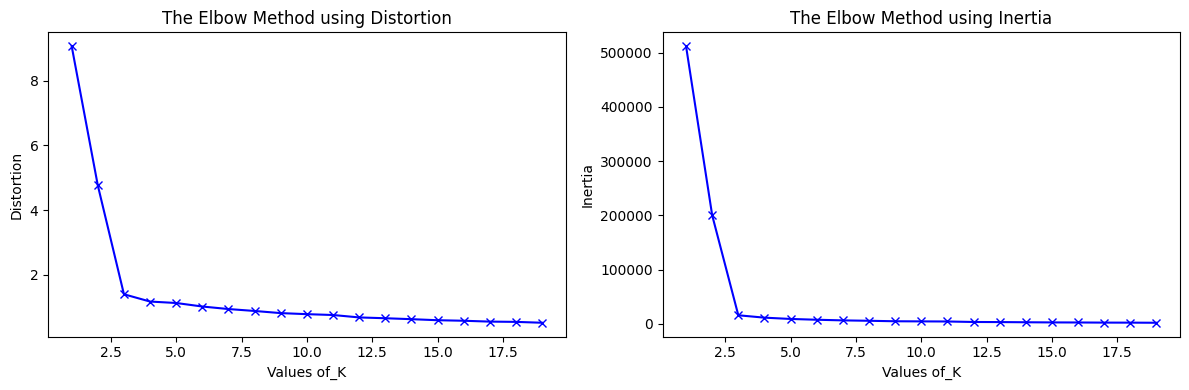

In [23]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [24]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 3, random_state=42)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['label'] = final_cluster_labels  

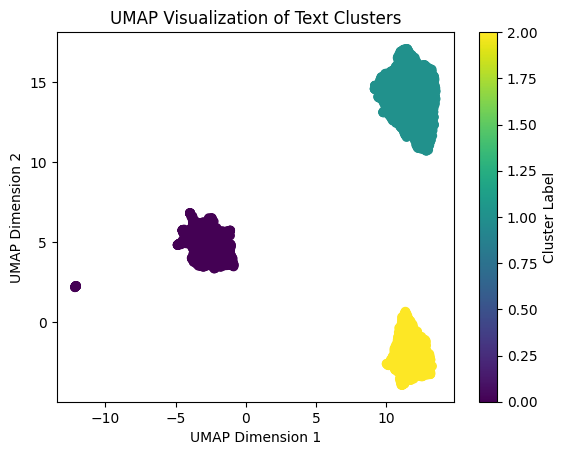

In [25]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('UMAP Dimension 1')
ax1.set_ylabel('UMAP Dimension 2')
ax1.set_title('UMAP Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [26]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Sum of distilbert embeddingsworkPr\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Sum of distilbert embeddingsworkPr"

Silhouette Coefficient: 0.87810218334198
Calinski-Harabasz Index: 92789.12573920784
Davies-Bouldin Index: 0.1682807772095061


## Manually check clusters

In [27]:
# create the community of the case ids(respondents) that are the result of the clustering
keys = ['zero', 'one', 'two']
communities = {key: [] for key in keys}

emb['id_case'] = emb.index

In [28]:
emb

,mentions_sum,label,id_case
200022,"[-0.227941528, -0.2221784741, 0.0722830296, -0...",0,200022
200039,"[-0.6598028392, -0.27716164660000003, -0.86524...",1,200039
200046,"[-0.5794350793, -0.2345397193, -0.55884777, -0...",1,200046
200053,"[-0.45105479660000003, -0.1378739029, -0.64340...",1,200053
200060,"[-0.7058136911, -0.5433786213, -0.7993942722, ...",1,200060
...,...,...,...
535292,"[-0.4805671274, -0.3407045835, -0.06159354, -0...",1,535292
535308,"[-0.2708855718, -0.042634843000000006, -0.6450...",1,535308
535360,"[-0.5909655169, -0.2776065506, -1.153657049, -...",1,535360
535414,"[-0.4220190793, -0.1548515521, -0.3687623702, ...",1,535414


In [29]:
for i in range(len(emb)):
    if emb['label'].iloc[i] == 1:
        communities['one'].append(emb['id_case'].iloc[i])
    elif emb['label'].iloc[i] == 0: 
        communities['zero'].append(emb['id_case'].iloc[i])
    elif emb['label'].iloc[i] == 2: 
        communities['two'].append(emb['id_case'].iloc[i])

In [30]:
demos

,POST_vote,POST_president,PRE_present_religion,PRE_age,PRE_education,PRE_race,PRE_sex,PRE_occupation
id_case,,,,,,,,
200022,1,3,12,37,3,4,2,1
200039,1,1,11,40,2,1,2,7
200046,1,1,2,41,3,4,1,1
200053,1,2,12,72,5,5,1,5
200060,1,1,10,71,3,1,2,5
...,...,...,...,...,...,...,...,...
535292,1,2,11,65,2,1,2,6
535308,1,2,11,54,4,1,2,1
535360,1,2,4,52,4,1,2,1


## AGE

In [31]:
age = demos['PRE_age']

In [32]:
# delete the null valued rows in the column 'age'
age = age.dropna()

In [33]:
# mean, var, std
print("mean of age:", np.mean(age))
print("variance of age:", np.var(age))
print("standard deviation of age:", np.std(age))

mean of age: 50.71404569892473
variance of age: 415.80398282586856
standard deviation of age: 20.391272221856795


In [34]:
# Dataframe age with each communities
age_0 = age.loc[communities['zero']]
age_1 = age.loc[communities['one']]
age_2 = age.loc[communities['two']]

# print cardinality, mean, var, std within the cluster.
# community_0
print("*community_0 in age")
print("how many:", len(age_0))
print("mean:", np.mean(age_0))
print("variance:", np.var(age_0))
print("std:", np.std(age_0))

# community_1
print("\n*community_1 in age ")
print("how many:", len(age_1))
print("mean:", np.mean(age_1))
print("variance:", np.var(age_1))
print("std:", np.std(age_1))

# community_2
print("\n*community_2 in age")
print("how many:", len(age_2))
print("mean:", np.mean(age_2))
print("variance:", np.var(age_2))
print("std:", np.std(age_2))


*community_0 in age
how many: 1337
mean: 45.00448765893792
variance: 459.52877567243553
std: 21.436622300923144

*community_1 in age 
how many: 2978
mean: 54.301208865010075
variance: 379.22660028478373
std: 19.473741301680676

*community_2 in age
how many: 1550
mean: 49.00967741935484
variance: 381.41345473465134
std: 19.52980938807779


(array([79.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 24., 39., 64., 75.,
        74., 78., 89., 73., 70., 69., 53., 53., 54., 60., 58., 62., 64.,
        51., 46., 35., 67.]),
 array([-9.        , -6.03333333, -3.06666667, -0.1       ,  2.86666667,
         5.83333333,  8.8       , 11.76666667, 14.73333333, 17.7       ,
        20.66666667, 23.63333333, 26.6       , 29.56666667, 32.53333333,
        35.5       , 38.46666667, 41.43333333, 44.4       , 47.36666667,
        50.33333333, 53.3       , 56.26666667, 59.23333333, 62.2       ,
        65.16666667, 68.13333333, 71.1       , 74.06666667, 77.03333333,
        80.        ]),
 <BarContainer object of 30 artists>)

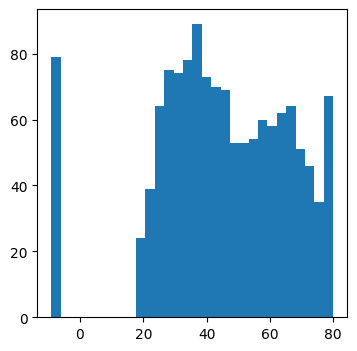

In [35]:
# it is the example below, use to see another community as well.
# Histogram of age in community 0
plt.rcParams["figure.figsize"] = (4,4) # set the figure size
plt.hist(age_0, bins = 30)

(array([ 52.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  23.,  22.,
         56.,  66.,  69.,  85.,  97., 106.,  65.,  57.,  82.,  67.,  91.,
         84.,  93.,  96.,  80.,  68.,  58.,  40.,  93.]),
 array([-9.        , -6.03333333, -3.06666667, -0.1       ,  2.86666667,
         5.83333333,  8.8       , 11.76666667, 14.73333333, 17.7       ,
        20.66666667, 23.63333333, 26.6       , 29.56666667, 32.53333333,
        35.5       , 38.46666667, 41.43333333, 44.4       , 47.36666667,
        50.33333333, 53.3       , 56.26666667, 59.23333333, 62.2       ,
        65.16666667, 68.13333333, 71.1       , 74.06666667, 77.03333333,
        80.        ]),
 <BarContainer object of 30 artists>)

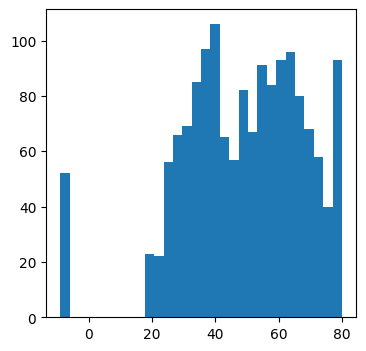

In [36]:
# it is the example below, use to see another community as well.
# Histogram of age in community 1
plt.rcParams["figure.figsize"] = (4,4) # set the figure size
plt.hist(age_2, bins = 30)

## PRESIDENT

In [37]:
politics = demos['POST_president']
politics = politics.dropna()

In [38]:
demos['POST_president'].value_counts()

POST_president
 1     3267
 2     2462
 3       69
 5       56
-9       53
 4       23
 12      16
 8        3
 11       2
 7        1
Name: count, dtype: int64

In [39]:
# Dataframe political ideology with each communities
politics_0 = politics.loc[communities['zero']]
politics_1 = politics.loc[communities['one']]
politics_2 = politics.loc[communities['two']]

print("How many in politics belong to community 0:", len(politics_0))
print("How many in politics belong to community 1:", len(politics_1))
print("How many in politics belong to community 2:", len(politics_2))

How many in politics belong to community 0: 1337
How many in politics belong to community 1: 2978
How many in politics belong to community 2: 1550


In [40]:
politics_0.value_counts()

POST_president
 1     657
 2     615
-9      20
 3      18
 5      14
 4       6
 12      5
 11      2
Name: count, dtype: int64

In [41]:
politics_1.value_counts()

POST_president
 1     1757
 2     1129
 3       34
 5       23
-9       17
 4       10
 12       6
 8        1
 7        1
Name: count, dtype: int64

In [42]:
politics_2.value_counts()

POST_president
 1     818
 2     677
 5      17
 3      15
-9      11
 4       6
 12      4
 8       2
Name: count, dtype: int64

(array([ 20.,   0.,   0., 657., 639.,  14.,   0.,   7.]),
 array([-9.   , -6.375, -3.75 , -1.125,  1.5  ,  4.125,  6.75 ,  9.375,
        12.   ]),
 <BarContainer object of 8 artists>)

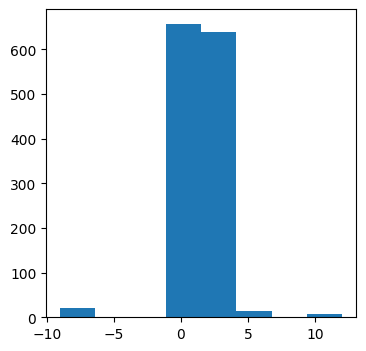

In [43]:
# it is the example below, use to see another community as well.
# Histogram of politics in community 0
plt.rcParams["figure.figsize"] = (4,4) # set the figure size
plt.hist(politics_0, bins = 8)

(array([ 11.,   0.,   0., 818., 698.,  17.,   2.,   4.]),
 array([-9.   , -6.375, -3.75 , -1.125,  1.5  ,  4.125,  6.75 ,  9.375,
        12.   ]),
 <BarContainer object of 8 artists>)

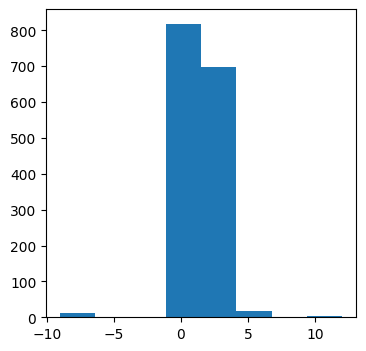

In [44]:
# it is the example below, use to see another community as well.
# Histogram of politics in community 1
plt.rcParams["figure.figsize"] = (4,4) # set the figure size
plt.hist(politics_2, bins = 8)

## EDUCATION

In [45]:
education = demos['PRE_education']
education = education.dropna()
education

id_case
200022    3
200039    2
200046    3
200053    5
200060    3
         ..
535292    2
535308    4
535360    4
535414    2
535469    5
Name: PRE_education, Length: 5952, dtype: int64

In [46]:
# Dataframe political ideology with each communities
education_0 = education.loc[communities['zero']]
education_1 = education.loc[communities['one']]
education_2 = education.loc[communities['two']]

print("How many in education belong to community 0:", len(education_0))
print("How many in education belong to community 1:", len(education_1))
print("How many in education belong to community 2:", len(education_2))

How many in education belong to community 0: 1337
How many in education belong to community 1: 2978
How many in education belong to community 2: 1550


In [47]:
education_0.value_counts()

PRE_education
 3    490
 4    313
 2    241
 5    219
 1     49
-2     17
-9      8
Name: count, dtype: int64

In [48]:
education_1.value_counts()

PRE_education
 3    911
 4    863
 5    762
 2    335
 1     61
-2     40
-9      5
-8      1
Name: count, dtype: int64

In [49]:
education_2.value_counts()

PRE_education
 3    565
 4    440
 5    298
 2    184
 1     46
-2     15
-9      2
Name: count, dtype: int64

(array([  8.,   0.,   0.,   0.,   0.,   0.,   0.,  17.,   0.,   0.,  49.,
        241., 490., 313., 219.]),
 array([-9.        , -8.06666667, -7.13333333, -6.2       , -5.26666667,
        -4.33333333, -3.4       , -2.46666667, -1.53333333, -0.6       ,
         0.33333333,  1.26666667,  2.2       ,  3.13333333,  4.06666667,
         5.        ]),
 <BarContainer object of 15 artists>)

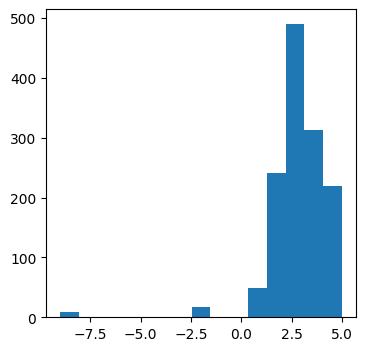

In [50]:
# it is the example below, use to see another community as well.
# Histogram of education in community 0
plt.rcParams["figure.figsize"] = (4,4) # set the figure size
plt.hist(education_0, bins = 15)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,  15.,   0.,   0.,  46.,
        184., 565., 440., 298.]),
 array([-9.        , -8.06666667, -7.13333333, -6.2       , -5.26666667,
        -4.33333333, -3.4       , -2.46666667, -1.53333333, -0.6       ,
         0.33333333,  1.26666667,  2.2       ,  3.13333333,  4.06666667,
         5.        ]),
 <BarContainer object of 15 artists>)

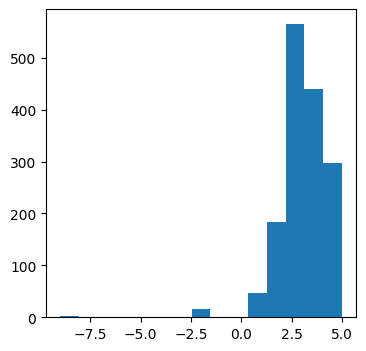

In [51]:
# it is the example below, use to see another community as well.
# Histogram of education in community 1
plt.rcParams["figure.figsize"] = (4,4) # set the figure size
plt.hist(education_2, bins = 15)

## RELIGION

In [52]:
religion = demos['PRE_present_religion']
religion = religion.dropna()

In [53]:
religion.value_counts()

PRE_present_religion
 1     1660
 2     1214
 11    1042
 12     974
 10     343
 9      253
 5      145
 3       88
 4       87
 7       52
-9       45
 8       25
 6       24
Name: count, dtype: int64

In [54]:
# Dataframe political ideology with each communities
religion_0 = religion.loc[communities['zero']]
religion_1 = religion.loc[communities['one']]
religion_2 = religion.loc[communities['two']]

print("How many in religion belong to community 0:", len(religion_0))
print("How many in religion belong to community 1:", len(religion_1))
print("How many in religion belong to community 2:", len(religion_2))

How many in religion belong to community 0: 1337
How many in religion belong to community 1: 2978
How many in religion belong to community 2: 1550


In [55]:
religion_0.value_counts()

PRE_present_religion
 1     310
 2     306
 12    264
 11    256
 10     63
 9      34
 5      25
 3      22
 4      20
-9      16
 7       8
 6       7
 8       6
Name: count, dtype: int64

In [56]:
religion_1.value_counts()

PRE_present_religion
 1     901
 2     586
 11    507
 12    425
 10    184
 9     144
 5      85
 4      44
 3      37
 7      31
-9      13
 8      13
 6       8
Name: count, dtype: int64

In [57]:
religion_2.value_counts()

PRE_present_religion
 1     425
 2     305
 12    273
 11    263
 10     94
 9      72
 5      32
 3      25
 4      23
-9      12
 7      12
 6       8
 8       6
Name: count, dtype: int64

## RACE

In [58]:
race = demos['PRE_race']
race = race.dropna()

In [59]:
race.value_counts()

PRE_race
 1    4498
 2     468
 3     446
 4     192
 6     179
 5     114
-9      51
-8       4
Name: count, dtype: int64

In [60]:
# Dataframe political ideology with each communities
race_0 = race.loc[communities['zero']]
race_1 = race.loc[communities['one']]
race_2 = race.loc[communities['two']]

print("How many in race belong to community 0:", len(race_0))
print("How many in race belong to community 1:", len(race_1))
print("How many in race belong to community 2:", len(race_2))

How many in race belong to community 0: 1337
How many in race belong to community 1: 2978
How many in race belong to community 2: 1550


In [61]:
race_0.value_counts()

PRE_race
 1    969
 3    130
 2    122
 4     47
 6     37
 5     17
-9     15
Name: count, dtype: int64

In [62]:
race_1.value_counts()

PRE_race
 1    2291
 2     237
 3     181
 4      96
 6      87
 5      64
-9      19
-8       3
Name: count, dtype: int64

In [63]:
race_2.value_counts()

PRE_race
 1    1177
 3     127
 2     100
 6      52
 4      47
 5      30
-9      16
-8       1
Name: count, dtype: int64

## SEX

In [64]:
sex = demos['PRE_sex']
sex = sex.dropna()

In [65]:
sex.value_counts()

PRE_sex
 2    3240
 1    2676
-9      36
Name: count, dtype: int64

In [66]:
# Dataframe political ideology with each communities
sex_0 = sex.loc[communities['zero']]
sex_1 = sex.loc[communities['one']]
sex_2 = sex.loc[communities['two']]

print("How many in sex belong to community 0:", len(sex_0))
print("How many in sex belong to community 1:", len(sex_1))
print("How many in sex belong to community 2:", len(sex_2))

How many in sex belong to community 0: 1337
How many in sex belong to community 1: 2978
How many in sex belong to community 2: 1550


In [67]:
sex_0.value_counts()

PRE_sex
 2    757
 1    569
-9     11
Name: count, dtype: int64

In [68]:
sex_1.value_counts()

PRE_sex
 2    1639
 1    1325
-9      14
Name: count, dtype: int64

In [69]:
sex_2.value_counts()

PRE_sex
 2    790
 1    749
-9     11
Name: count, dtype: int64

## JOB

In [70]:
job = demos['PRE_occupation']
job = job.dropna()

In [71]:
job.value_counts()

PRE_occupation
 1    3633
 5    1448
 7     311
 6     204
 2     172
 4      86
 8      67
-2      31
Name: count, dtype: int64

In [72]:
# Dataframe political ideology with each communities
job_0 = job.loc[communities['zero']]
job_1 = job.loc[communities['one']]
job_2 = job.loc[communities['two']]

print("How many in job belong to community 0:", len(job_0))
print("How many in job belong to community 1:", len(job_1))
print("How many in job belong to community 2:", len(job_2))

How many in job belong to community 0: 1337
How many in job belong to community 1: 2978
How many in job belong to community 2: 1550


In [73]:
job_0.value_counts()

PRE_occupation
 1    874
 5    233
 7     79
 6     53
 2     37
 8     26
 4     19
-2     16
Name: count, dtype: int64

In [74]:
job_1.value_counts()

PRE_occupation
 1    1691
 5     877
 7     146
 6     100
 2      89
 4      43
 8      25
-2       7
Name: count, dtype: int64

In [75]:
job_2.value_counts()

PRE_occupation
 1    1014
 5     315
 7      84
 6      49
 2      44
 4      21
 8      15
-2       8
Name: count, dtype: int64

## Compare the communities' demographics

### Visualize multiple graph

In [76]:
# Display graphs grouped by the community label
import matplotlib.pyplot as plt

# List of data for each plot
data_0 = [age_0, politics_0, education_0, religion_0, race_0, sex_0, job_0]
data_1 = [age_1, politics_1, education_1, religion_1, race_1, sex_1, job_1]
data_2 = [age_2, politics_2, education_2, religion_2, race_2, sex_2, job_2]



*The number of the community members: 1337


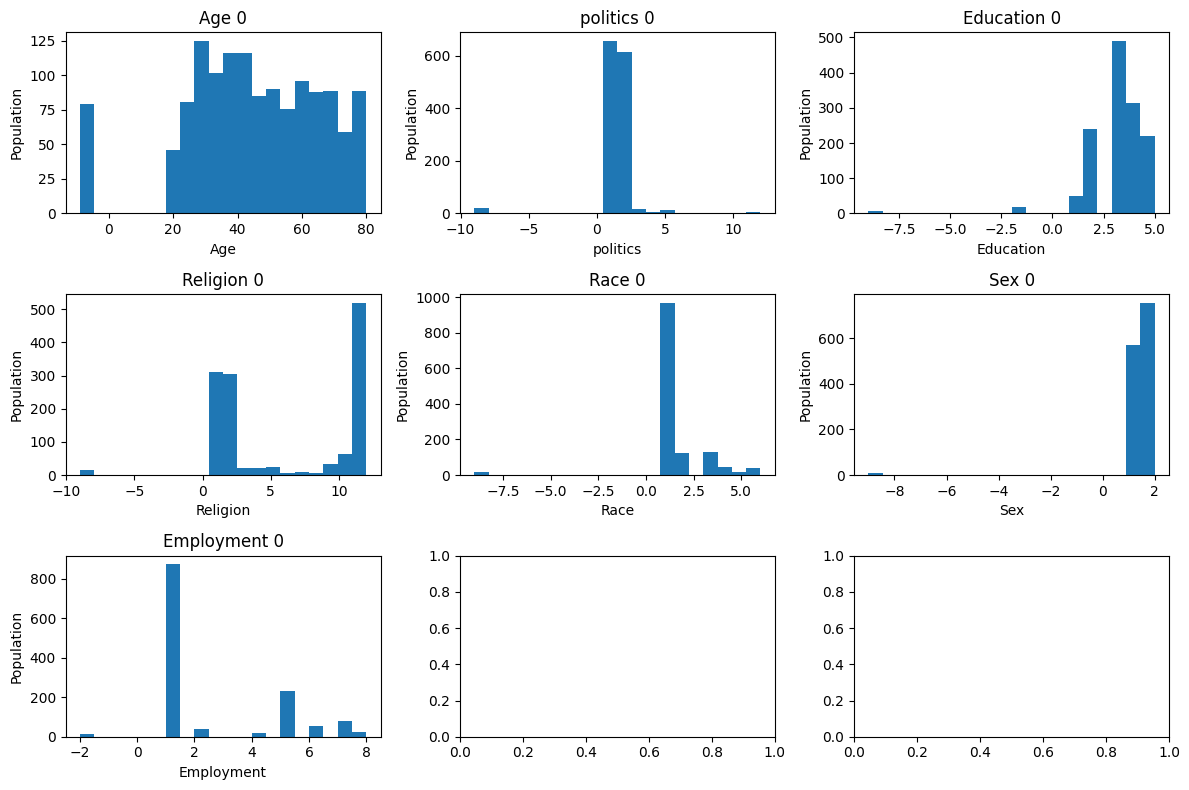

In [77]:
# Create subplots dynamically
fig, axes = plt.subplots(3, 3,  figsize=(12, 8))


# Create a histogram on one of the subplots
axes[0, 0].hist(age_0, bins=20)
axes[0, 0].set_title('Age 0')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[0, 1].hist(politics_0, bins=20)
axes[0, 1].set_title('politics 0')
axes[0, 1].set_xlabel('politics')
axes[0, 1].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[0, 2].hist(education_0, bins=20)
axes[0, 2].set_title('Education 0')
axes[0, 2].set_xlabel('Education')
axes[0, 2].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 0].hist(religion_0, bins=20)
axes[1, 0].set_title('Religion 0')
axes[1, 0].set_xlabel('Religion')
axes[1, 0].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 1].hist(race_0, bins=20)
axes[1, 1].set_title('Race 0')
axes[1, 1].set_xlabel('Race')
axes[1, 1].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 2].hist(sex_0, bins=20)
axes[1, 2].set_title('Sex 0')
axes[1, 2].set_xlabel('Sex')
axes[1, 2].set_ylabel('Population')


# Create a histogram on one of the subplots
axes[2, 0].hist(job_0, bins=20)
axes[2, 0].set_title('Employment 0')
axes[2, 0].set_xlabel('Employment')
axes[2, 0].set_ylabel('Population')

# Adjust layout
plt.tight_layout()

# Print the number of the community members:
print("\n\n*The number of the community members:", len(communities["zero"]))

# Show the combined plots
plt.show()




*The number of the community members: 2978


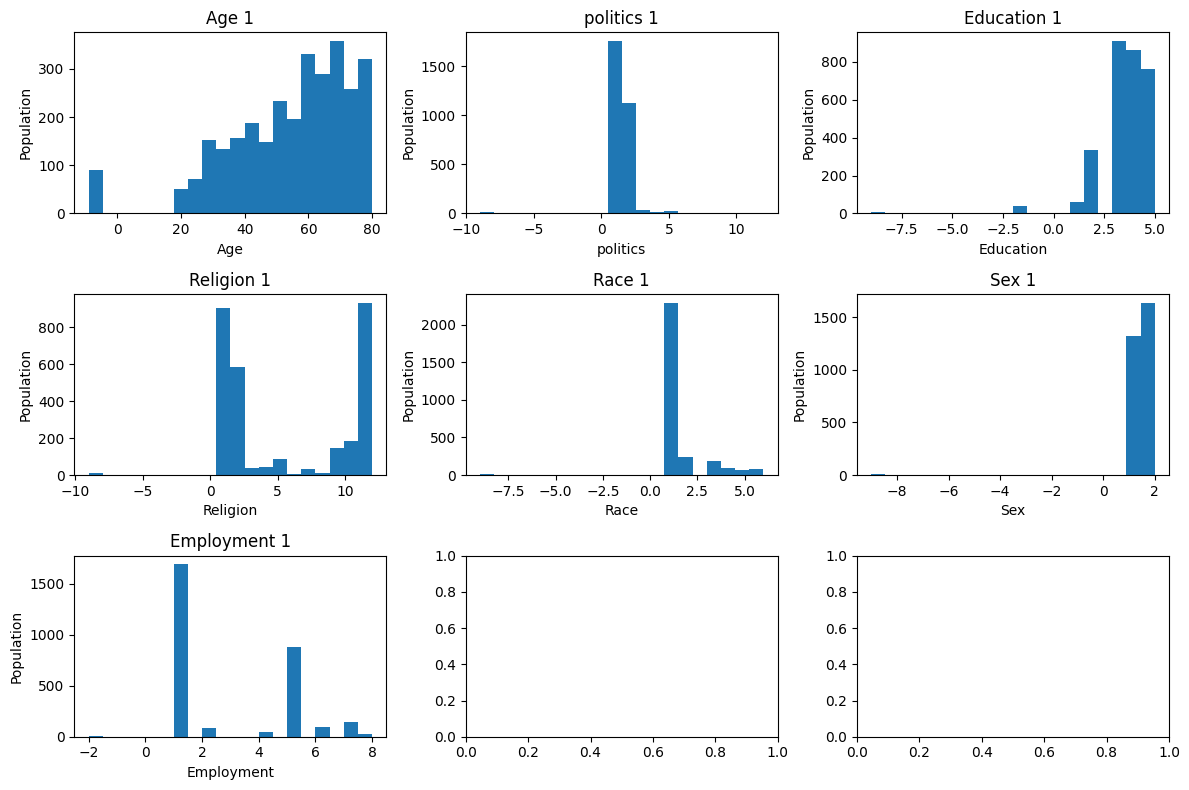

In [78]:
# Create subplots dynamically
fig, axes = plt.subplots(3, 3,  figsize=(12, 8))


# Create a histogram on one of the subplots
axes[0, 0].hist(age_1, bins=20)
axes[0, 0].set_title('Age 1')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[0, 1].hist(politics_1, bins=20)
axes[0, 1].set_title('politics 1')
axes[0, 1].set_xlabel('politics')
axes[0, 1].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[0, 2].hist(education_1, bins=20)
axes[0, 2].set_title('Education 1')
axes[0, 2].set_xlabel('Education')
axes[0, 2].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 0].hist(religion_1, bins=20)
axes[1, 0].set_title('Religion 1')
axes[1, 0].set_xlabel('Religion')
axes[1, 0].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 1].hist(race_1, bins=20)
axes[1, 1].set_title('Race 1')
axes[1, 1].set_xlabel('Race')
axes[1, 1].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 2].hist(sex_1, bins=20)
axes[1, 2].set_title('Sex 1')
axes[1, 2].set_xlabel('Sex')
axes[1, 2].set_ylabel('Population')


# Create a histogram on one of the subplots
axes[2, 0].hist(job_1, bins=20)
axes[2, 0].set_title('Employment 1')
axes[2, 0].set_xlabel('Employment')
axes[2, 0].set_ylabel('Population')

# Adjust layout
plt.tight_layout()

# Print the number of the community members:
print("\n\n*The number of the community members:", len(communities["one"]))

# Show the combined plots
plt.show()




*The number of the community members: 1550


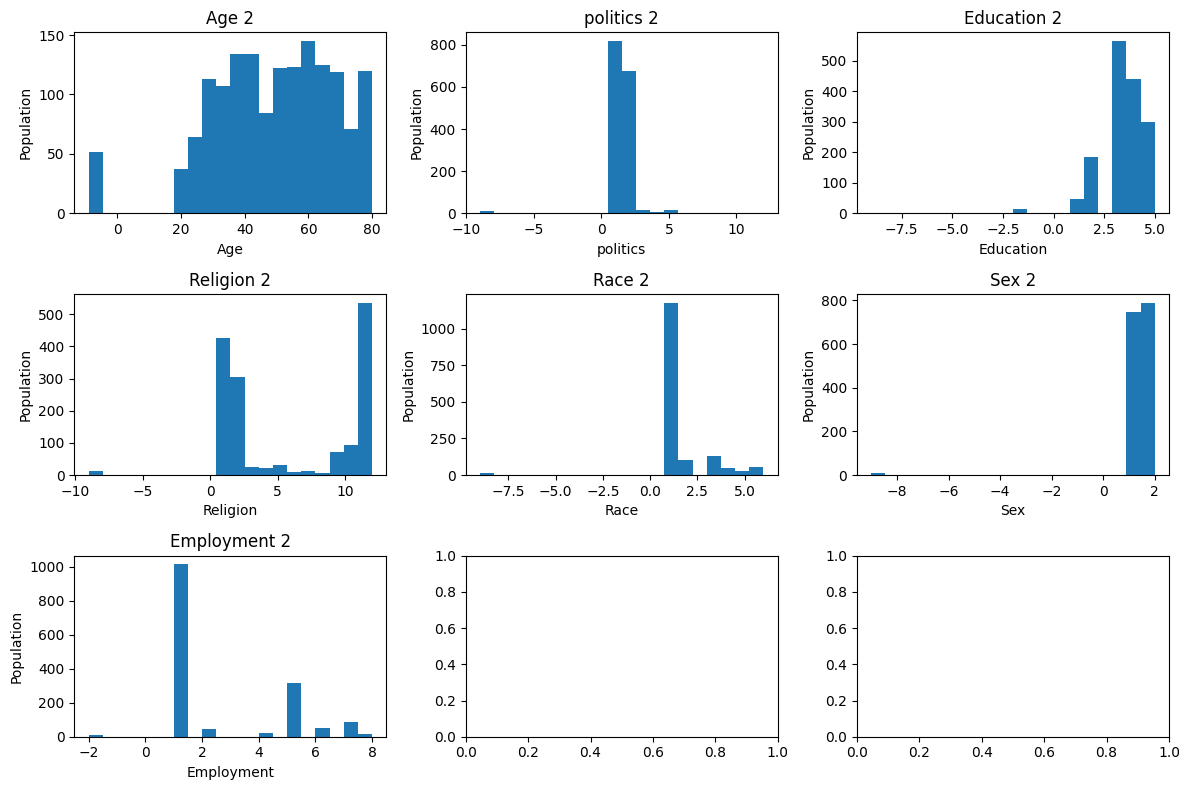

In [79]:
# Create subplots dynamically
fig, axes = plt.subplots(3, 3,  figsize=(12, 8))


# Create a histogram on one of the subplots
axes[0, 0].hist(age_2, bins=20)
axes[0, 0].set_title('Age 2')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[0, 1].hist(politics_2, bins=20)
axes[0, 1].set_title('politics 2')
axes[0, 1].set_xlabel('politics')
axes[0, 1].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[0, 2].hist(education_2, bins=20)
axes[0, 2].set_title('Education 2')
axes[0, 2].set_xlabel('Education')
axes[0, 2].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 0].hist(religion_2, bins=20)
axes[1, 0].set_title('Religion 2')
axes[1, 0].set_xlabel('Religion')
axes[1, 0].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 1].hist(race_2, bins=20)
axes[1, 1].set_title('Race 2')
axes[1, 1].set_xlabel('Race')
axes[1, 1].set_ylabel('Population')

# Create a histogram on one of the subplots
axes[1, 2].hist(sex_2, bins=20)
axes[1, 2].set_title('Sex 2')
axes[1, 2].set_xlabel('Sex')
axes[1, 2].set_ylabel('Population')


# Create a histogram on one of the subplots
axes[2, 0].hist(job_2, bins=20)
axes[2, 0].set_title('Employment 2')
axes[2, 0].set_xlabel('Employment')
axes[2, 0].set_ylabel('Population')

# Adjust layout
plt.tight_layout()

# Print the number of the community members:
print("\n\n*The number of the community members:", len(communities["two"]))

# Show the combined plots
plt.show()


**result**

* Worthy variables: Age, Politics, Education, Religion, Sex

## ANOVA for the continuous variable
Assumptions: ANOVA assumes homogeneity of variances (similar variances in groups), normal distribution of residuals, and independence of observations.

check if the data are approximately normally distributed within each cluster and if the variances across clusters are roughly equal.

### AGE

In [80]:
# print cardinality, mean, var, std within the cluster.
# community_0
print("*community_0 in age")
print("how many:", len(age_0))
print("mean:", np.mean(age_0))
print("variance:", np.var(age_0))
print("std:", np.std(age_0))

# community_1
print("\n*community_1 in age ")
print("how many:", len(age_1))
print("mean:", np.mean(age_1))
print("variance:", np.var(age_1))
print("std:", np.std(age_1))

# community_2
print("\n*community_2 in age ")
print("how many:", len(age_2))
print("mean:", np.mean(age_2))
print("variance:", np.var(age_2))
print("std:", np.std(age_2))


*community_0 in age
how many: 1337
mean: 45.00448765893792
variance: 459.52877567243553
std: 21.436622300923144

*community_1 in age 
how many: 2978
mean: 54.301208865010075
variance: 379.22660028478373
std: 19.473741301680676

*community_2 in age 
how many: 1550
mean: 49.00967741935484
variance: 381.41345473465134
std: 19.52980938807779


* ANOVA requires homogeneous variance -> Levene's test for the verification.

### Levene's test

In [81]:
import scipy.stats as stats

In [82]:
# Age

# Assuming you have your data in separate groups
age_0
age_1
age_2


# Perform Levene's test
statistic, p_value = stats.levene(age_0, age_1, age_2)

# Print the results
print("Levene's Test Statistic:", statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of unequal variances.")
else:
    print("Fail to reject the null hypothesis. Variances are likely homogeneous.")


Levene's Test Statistic: 11.03682369513849
P-value: 1.6435024438632498e-05
Reject the null hypothesis. There is evidence of unequal variances.


In [83]:
age_0[:5]

id_case
200022    37
200084    37
200121    37
200138    55
200152    30
Name: PRE_age, dtype: int64

**NOT suitable for the ANOVA because the variances are not homogeneous", -> Welch's ANOVA**

###  Welch's ANOVA

In [84]:
# prepare each df with the community label information
df_com0 = pd.DataFrame({'age': age_0, 'community': 0})
df_com1 = pd.DataFrame({'age': age_1, 'community': 1})
df_com2 = pd.DataFrame({'age': age_2, 'community': 2})

In [85]:
df = pd.concat([df_com0, df_com1, df_com2]).reset_index(drop = True)

In [87]:
%pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [88]:
import pingouin as pg 
  
# perform Welch's ANOVA 
pg.welch_anova(dv='age', between='community', data=df) 

,Source,ddof1,ddof2,F,p-unc,np2
0,community,2,2969.207802,103.044652,5.408025e-44,0.035675



**Result**:This extremely small **p-value(group PR(>F))** indicates a **highly significant difference** between the means of the two groups.

### Post-hoc ANOVA: Games-Howell test

In [89]:
posthoc_results = pg.pairwise_gameshowell(dv = 'age', between = 'community', data = df)

In [90]:
# Better formatted print for Games-Howell results
print("\nGames-Howell Post-Hoc Test Results:")
for index, row in posthoc_results.iterrows():
    print(f"Comparison: Group {row['A']} vs Group {row['B']}")
    print(f"  Mean of Group {row['A']}: {row['mean(A)']:.3f}")
    print(f"  Mean of Group {row['B']}: {row['mean(B)']:.3f}")
    print(f"  Mean Difference (Group {row['A']} - Group {row['B']}): {row['diff']:.3f}")
    print(f"  Standard Error: {row['se']:.3f}")
    print(f"  T-Statistic: {row['T']:.3f}")
    print(f"  Degrees of Freedom: {row['df']:.3f}")
    print(f"  p-value: {row['pval']:.4e}")
    print(f"  Hedges' g: {row['hedges']:.3f}")
    print("-" * 50)


Games-Howell Post-Hoc Test Results:
Comparison: Group 0.0 vs Group 1.0
  Mean of Group 0.0: 45.004
  Mean of Group 1.0: 54.301
  Mean Difference (Group 0.0 - Group 1.0): -9.297
  Standard Error: 0.687
  T-Statistic: -13.541
  Degrees of Freedom: 2363.351
  p-value: 1.3156e-13
  Hedges' g: -0.462
--------------------------------------------------
Comparison: Group 0.0 vs Group 2.0
  Mean of Group 0.0: 45.004
  Mean of Group 2.0: 49.010
  Mean Difference (Group 0.0 - Group 2.0): -4.005
  Standard Error: 0.768
  T-Statistic: -5.213
  Degrees of Freedom: 2727.788
  p-value: 5.9639e-07
  Hedges' g: -0.196
--------------------------------------------------
Comparison: Group 1.0 vs Group 2.0
  Mean of Group 1.0: 54.301
  Mean of Group 2.0: 49.010
  Mean Difference (Group 1.0 - Group 2.0): 5.292
  Standard Error: 0.611
  T-Statistic: 8.657
  Degrees of Freedom: 3130.360
  p-value: 0.0000e+00
  Hedges' g: 0.271
--------------------------------------------------


### Post-hoc analysis: standardized residuals

In [91]:
# Calculate the group means
group_means = df.groupby('community')['age'].mean()

# Calculate residuals for each observation
df['residual'] = df.apply(lambda row: row['age'] - group_means[row['community']], axis=1)

# Calculate the standard deviation of the residuals
residual_std = np.std(df['residual'], ddof=1)

# Calculate standardized residuals
df['standardized_residual'] = df['residual'] / residual_std

# Display standardized residuals by group
print("\nStandardized Residuals by Group:")
for group, data in df.groupby('community'):
    print(f"\nGroup {group}:")
    print(data[['age', 'residual', 'standardized_residual']].head())  # Show top few rows for each group

# Summary statistics of standardized residuals by group
print("\nSummary of Standardized Residuals by Group:")
print(df.groupby('community')['standardized_residual'].describe())


Standardized Residuals by Group:

Group 0:
   age   residual  standardized_residual
0   37  -8.004488              -0.401139
1   37  -8.004488              -0.401139
2   37  -8.004488              -0.401139
3   55   9.995512               0.500918
4   30 -15.004488              -0.751939

Group 1:
      age   residual  standardized_residual
1337   40 -14.301209              -0.716694
1338   41 -13.301209              -0.666580
1339   72  17.698791               0.886962
1340   71  16.698791               0.836847
1341   43 -11.301209              -0.566352

Group 2:
      age   residual  standardized_residual
4315   54   4.990323               0.250086
4316   80  30.990323               1.553057
4317   24 -25.009677              -1.253341
4318   73  23.990323               1.202257
4319   50   0.990323               0.049629

Summary of Standardized Residuals by Group:
            count          mean       std       min       25%       50%  \
community                                 

**Interpretation**
* The lack of extreme standardized_residuals |value| > 2 means that while there are some extreme values but outliers are not found. 
* The residuals' spread is slightly different, but the distributions are not drastically different. 

## Chi-square test for categorical variable
- one variable: feature, the other one: label

In [92]:
# Create a dataframe with participants id and their community label
label_0 = pd.DataFrame(data= [0 for i in range(len(communities['zero']))], index = list(communities['zero']))
label_1 = pd.DataFrame(data= [1 for i in range(len(communities['one']))], index = list(communities['one']))
label_2 = pd.DataFrame(data = [2 for i in range(len(communities['two']))], index = list(communities['two']) )

In [93]:
print(len(label_0), len(label_1), len(label_2))

1337 2978 1550


In [94]:
label_0

,0
200022,0
200084,0
200121,0
200138,0
200152,0
...,...
534008,0
534367,0
534633,0
534992,0


In [95]:
# it will give the index into a new column, and setting the index numerically aligned. 
label_0 = label_0.reset_index()
label_1 = label_1.reset_index()
label_2 = label_2.reset_index()

In [96]:
labels = pd.concat([label_0, label_1, label_2], axis = 0, ignore_index = True)
labels = labels.rename(columns = { 0 : 'label'})

In [97]:
labels

,index,label
0,200022,0
1,200084,0
2,200121,0
3,200138,0
4,200152,0
...,...,...
5860,533265,2
5861,533289,2
5862,534589,2
5863,534640,2


**calculate expected frequencies**

In [98]:
# Sort the column 'index' into alphabetical order
labels = labels.sort_values(by='index')
labels = labels.reset_index()
labels = labels[['index', 'label']]

In [99]:
sex

id_case
200022    2
200039    2
200046    1
200053    1
200060    2
         ..
535292    2
535308    2
535360    2
535414    1
535469    2
Name: PRE_sex, Length: 5952, dtype: int64

In [100]:
# Sort the dataframe into alphabetical order
sex = sex.reset_index()
sex = sex.sort_values(by = 'id_case')

politics = politics.reset_index()
politics = politics.sort_values(by = 'id_case')

education = education.reset_index()
education = education.sort_values(by = 'id_case')

job = job.reset_index()
job = job.sort_values(by = 'id_case')

religion = religion.reset_index()
religion = religion.sort_values(by = 'id_case')

In [101]:
sex

,id_case,PRE_sex
0,200022,2
1,200039,2
2,200046,1
3,200053,1
4,200060,2
...,...,...
5947,535292,2
5948,535308,2
5949,535360,2
5950,535414,1


In [102]:
# Only selects the participants that also remains in the labels' id_case info.
sex = sex[sex['id_case'].isin(labels['index'])].reset_index()
sex = sex[['id_case', 'PRE_sex']]

politics = politics[politics['id_case'].isin(labels['index'])].reset_index()
politics = politics[['id_case', 'POST_president']]

education = education[education['id_case'].isin(labels['index'])].reset_index()
education = education[['id_case', 'PRE_education']]

job = job[job['id_case'].isin(labels['index'])].reset_index()
job = job[['id_case', 'PRE_occupation']]

religion = religion[religion['id_case'].isin(labels['index'])].reset_index()
religion = religion[['id_case', 'PRE_present_religion']]

In [103]:
labels['label'].value_counts()

label
1    2978
2    1550
0    1337
Name: count, dtype: int64

In [104]:
# check if the order of the particpant column is identical to the label column - sex
cnt = 0
for i in range(len(labels)): 
    if sex['id_case'].loc[i] == labels['index'].loc[i]: 
        pass
    else:
        cnt += 1
print("sex - not identical:", cnt)

sex - not identical: 0


In [105]:
# check if the order of the particpant column is identical to the label column - politics
cnt = 0
for i in range(len(labels)): 
    if politics['id_case'].loc[i] == labels['index'].loc[i]: 
        pass
    else:
        cnt += 1
print("politics - not identical:", cnt)

politics - not identical: 0


In [106]:
# check if the order of the particpant column is identical to the label column - education
cnt = 0
for i in range(len(labels)): 
    if education['id_case'].loc[i] == labels['index'].loc[i]: 
        pass
    else:
        cnt += 1
print("education - not identical:", cnt)

education - not identical: 0


In [107]:
# check if the order of the particpant column is identical to the label column - employment
cnt = 0
for i in range(len(labels)): 
    if job['id_case'].loc[i] == labels['index'].loc[i]: 
        pass
    else:
        cnt += 1
print("employment - not identical:", cnt)

employment - not identical: 0


In [108]:
# check if the order of the particpant column is identical to the label column - income
cnt = 0
for i in range(len(labels)): 
    if religion['id_case'].loc[i] == labels['index'].loc[i]: 
        pass
    else:
        cnt += 1
print("religion - not identical:", cnt)

religion - not identical: 0


In [109]:
from scipy.stats import chi2_contingency

### SEX

In [110]:
sex['PRE_sex'].value_counts()

PRE_sex
 2    3186
 1    2643
-9      36
Name: count, dtype: int64

### Check the expected frequency
* It is supposed to be, Every cell > 0, 80% of the cells >= 5

In [111]:
# Create a contingency table
contingency_table = pd.crosstab(sex['PRE_sex'], labels['label'])

In [112]:
contingency_table.head()

label,0,1,2
PRE_sex,,,
-9,11,14,11
1,569,1325,749
2,757,1639,790


In [113]:
contingency_table_filtered = contingency_table.loc[[1,2]]

In [114]:
# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    10.5195
Degrees of Freedom:       2
p-value:                  5.1965e-03

Expected Frequencies (rounded):
label         0        1       2
PRE_sex                         
1        601.24  1343.94  697.82
2        724.76  1620.06  841.18


### Influence of a label on the chi-square test: residuals calculations

In [115]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    10.5195
Degrees of Freedom:       2
p-value:                  5.1965e-03

Expected Frequencies (rounded):
label         0        1       2
PRE_sex                         
1        601.24  1343.94  697.82
2        724.76  1620.06  841.18

Standardized Residuals:
label       0     1     2
PRE_sex                  
1       -1.31 -0.52  1.94
2        1.20  0.47 -1.76

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result:**
* Assumption: expected frequency is met
* p is below 0.05 -> reject the null-hypothesis
* The distribution of the feature(**sex**) **is significantly different** across different clusters. 
* The lack of extreme residuals(Empty DataFrame for the extreme standardized residuals |value| > 2) indicates that while there are significant differences overall, these differences are not driven by extreme deviations in specific cells.

### Pairwise Comparison with residuals interpretation

In [116]:
import itertools
from statsmodels.stats.multitest import multipletests

In [117]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table_filtered.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [118]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table_filtered.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [119]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [120]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [121]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   1.1217    2.8956e-01     8.6867e-01     
(0, 2)                   9.2732    2.3253e-03     6.9758e-03     
(1, 2)                   6.2511    1.2411e-02     3.7234e-02     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value is 0.868 >> 0.05 --- no difference significantly
    * (0, 2) community: adjusted p-value is 0.006976 << 0.05 --- significant difference
    * (1, 2) community: adjusted p-value is 0.037 < 0.05 --- significant difference

In [122]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table_filtered.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
            0     1
PRE_sex            
1       -0.68  0.45
2        0.60 -0.40

Pair: (0, 2)
            0     2
PRE_sex            
1       -1.66  1.54
2        1.53 -1.42

Pair: (1, 2)
            1     2
PRE_sex            
1       -1.09  1.51
2        1.00 -1.39


**Interpretation: Residuals**
* Pair (0, 1): Derivatives are relatively modest with no extreme value, so the distribution of 'sex' variable across communities 0 and 1 is reasonably close to what was expected.
* Pair (0, 2): There are notable deviations, meaning Community 0 and Community 2 show significant differences compared to other pair of communities.
* Pair (1, 2): Less close to each other compared to (0, 1) pair but more closer between communities compared to the (0, 2) pair. 

### Politics

### Check the expected frequency
* It is supposed to be, Every cell > 0, 80% of the cells >= 5

In [123]:
# Create a contingency table
contingency_table = pd.crosstab(politics['POST_president'], labels['label'])

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    60.0719
Degrees of Freedom:       18
p-value:                  1.9920e-06

Expected Frequencies (rounded):
label                0        1       2
POST_president                         
-9               10.94    24.37   12.69
 1              736.77  1641.07  854.15
 2              551.90  1229.28  639.82
 3               15.27    34.02   17.71
 4                5.02    11.17    5.81
 5               12.31    27.42   14.27
 7                0.23     0.51    0.26
 8                0.68     1.52    0.79
 11               0.46     1.02    0.53
 12               3.42     7.62    3.96


### Cut off the dataset

In [124]:
# filter only the 1,2 voted participants

contingency_table_filtered = contingency_table.loc[[1, 2]]

In [125]:
contingency_table_filtered

label,0,1,2
POST_president,,,
1,657,1757,818
2,615,1129,677


In [126]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[ 727.24287989 1650.01804352  854.7390766 ]
 [ 544.75712011 1235.98195648  640.2609234 ]]
All expected frequencies are >= 5. The Chi-Square test can be used.


* Assumption is met regarding the expected frequency

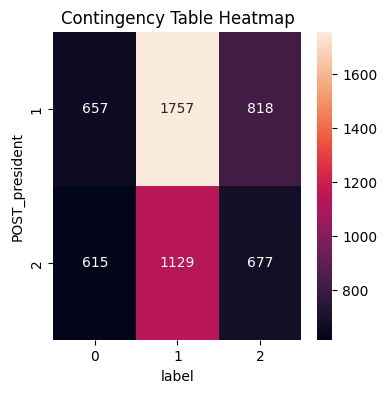

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table_filtered, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [128]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    35.7256
Degrees of Freedom:       2
p-value:                  1.7470e-08

Expected Frequencies (rounded):
label                0        1       2
POST_president                         
1               727.24  1650.02  854.74
2               544.76  1235.98  640.26


### Influence of a label on the overall chi-square test: residuals calculations

In [129]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    35.7256
Degrees of Freedom:       2
p-value:                  1.7470e-08

Expected Frequencies (rounded):
label                0        1       2
POST_president                         
1               727.24  1650.02  854.74
2               544.76  1235.98  640.26

Standardized Residuals:
label              0     1     2
POST_president                  
1              -2.60  2.63 -1.26
2               3.01 -3.04  1.45

Extreme Standardized Residuals (|value| > 2):
label                  0         1   2
POST_president                        
1              -2.604729  2.633699 NaN
2               3.009545 -3.043018 NaN


**Result:**
* Assumption: expected frequency is met
* p is below 0.05 -> reject the null-hypothesis
* The distribution of the feature(**politics**) **is significantly different** across different clusters. 
* Looking at the Residuals, Community 0 is overrerpesented for label 2(Trump) and underrepresented for label 1(Biden). Community 1 is the opposite. So, Trump is more frequent than expected in Community 0 and Biden is more frequent than expected in Community 1.

### Pairwise Comparison with residuals interpretation

In [130]:
import itertools
from statsmodels.stats.multitest import multipletests

In [131]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table_filtered.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [132]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table_filtered.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [133]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [134]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [135]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   30.5044   3.3311e-08     9.9932e-08     
(0, 2)                   2.4718    1.1591e-01     3.4772e-01     
(1, 2)                   15.1919   9.7118e-05     2.9135e-04     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value << 0.05 --- significant difference
    * (0, 2) community: adjusted p-value > 0.05 --- no significant difference
    * (1, 2) community: adjusted p-value << 0.05 --- significant difference

In [136]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table_filtered.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
                   0     1
POST_president            
1              -3.00  1.99
2               3.53 -2.34

Pair: (0, 2)
                   0     2
POST_president            
1              -0.81  0.75
2               0.86 -0.80

Pair: (1, 2)
                   1     2
POST_president            
1               1.47 -2.05
2              -1.76  2.45


**Interpretation: Residuals**
* Pair (0, 1): Community 0 is very underrepresented for Biden and overrepresented for Trump compared to Community 1. Community 1 is the opposite.  
* Pair (0, 2): The residuals are closer to the 0, meaning the community 0 and 2 distributions are quite similar with minor deviations. 
* Pair (1, 2): Community 1 is overrepresented for Biden and underrepresented for Trump compared to community 2. Community 2 is the opposite. 

### Education

In [137]:
# Create a contingency table
contingency_table = pd.crosstab(education['PRE_education'], labels['label'])

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    123.3401
Degrees of Freedom:       14
p-value:                  1.3925e-19

Expected Frequencies (rounded):
label               0       1       2
PRE_education                        
-9               3.42    7.62    3.96
-8               0.23    0.51    0.26
-2              16.41   36.56   19.03
 1              35.56   79.21   41.23
 2             173.25  385.90  200.85
 3             448.17  998.25  519.57
 4             368.39  820.54  427.08
 5             291.56  649.42  338.01


* Assumption is met regarding the expected frequency that 80% of the cells >= 5

### Chi-Square test

In [138]:
contingency_table_filtered = contingency_table.loc[[-9, -2, 1,2,3,4,5]]

In [139]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    122.3635
Degrees of Freedom:       12
p-value:                  2.0864e-20

Expected Frequencies (rounded):
label               0       1       2
PRE_education                        
-9               3.42    7.62    3.96
-2              16.42   36.55   19.03
 1              35.57   79.20   41.23
 2             173.28  385.83  200.89
 3             448.25  998.09  519.66
 4             368.45  820.40  427.15
 5             291.61  649.31  338.07


p is below 0.05 -> reject the null-hypothesis

**Result:**
The distribution of the feature(education) **is significantly different** across different clusters.

### Influence of a label on the overall chi-square test: residuals calculations

In [140]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    122.3635
Degrees of Freedom:       12
p-value:                  2.0864e-20

Expected Frequencies (rounded):
label               0       1       2
PRE_education                        
-9               3.42    7.62    3.96
-2              16.42   36.55   19.03
 1              35.57   79.20   41.23
 2             173.28  385.83  200.89
 3             448.25  998.09  519.66
 4             368.45  820.40  427.15
 5             291.61  649.31  338.07

Standardized Residuals:
label             0     1     2
PRE_education                  
-9             2.48 -0.95 -0.99
-2             0.14  0.57 -0.92
 1             2.25 -2.04  0.74
 2             5.14 -2.59 -1.19
 3             1.97 -2.76  1.99
 4            -2.89  1.49  0.62
 5            -4.25  4.42 -2.18

Extreme Standardized Residuals (|value| > 2):
label                 0         1         2
PRE_education                              
-9             2.476562       NaN  

**Result:**
* The distribution of the feature(**education**) **is significantly different** across different clusters. 
* Looking at the Residuals, Community 0 is overrerpesented for label 1 and especially 2 but underrepresented for the 4, and extraordinarily 5. Community 1 is especially overrepresented by label 5 but underrepresented by label 1,2,3. Community 2 is underrepresented for 5. 

### Pairwise Comparison with residuals interpretation

In [141]:
import itertools
from statsmodels.stats.multitest import multipletests

In [142]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table_filtered.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [143]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table_filtered.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [144]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [145]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [146]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   102.2370  8.5630e-20     2.5689e-19     
(0, 2)                   34.7617   4.7927e-06     1.4378e-05     
(1, 2)                   33.7591   7.4875e-06     2.2463e-05     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value <<< 0.05 --- significant difference
    * (0, 2) community: adjusted p-value << 0.05 --- significant difference
    * (1, 2) community: adjusted p-value << 0.05 --- significant difference

In [147]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table_filtered.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
                  0     1
PRE_education            
-9             1.98 -1.33
-2            -0.16  0.11
 1             2.55 -1.71
 2             4.68 -3.13
 3             2.68 -1.79
 4            -2.70  1.81
 5            -4.88  3.27

Pair: (0, 2)
                  0     2
PRE_education            
-9             1.57 -1.45
-2             0.57 -0.53
 1             0.75 -0.70
 2             3.15 -2.92
 3             0.06 -0.06
 4            -1.91  1.78
 5            -1.32  1.23

Pair: (1, 2)
                  1     2
PRE_education            
-9             0.18 -0.26
-2             0.64 -0.88
 1            -1.12  1.55
 2            -0.34  0.47
 3            -1.91  2.65
 4             0.21 -0.29
 5             2.46 -3.41


**Interpretation: Residuals**
* Pair (0, 1): Community 0 is overrepresented for label 2 but underrepresented for label 5 compared to Community 1. Community 1 os overrepresented for label 5 but under- for label 2. 
* Pair (0, 2): Community 0 is overrepresented for label 2 compared to Community 2. Community 2 is underrepresented for label 2 comparably. 
* Pair (1, 2): Communoity 1 is overrepresented for label 5 compared to Community 2. Community 2 is overrepresented for label 3 but under for label 5. 

### Job

In [148]:
# Create a contingency table
contingency_table = pd.crosstab(job['PRE_occupation'], labels['label'])

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    116.6154
Degrees of Freedom:       14
p-value:                  2.8877e-18

Expected Frequencies (rounded):
label                0        1       2
PRE_occupation                         
-2                7.07    15.74    8.19
 1              815.88  1817.27  945.86
 2               38.75    86.32   44.93
 4               18.92    42.14   21.94
 5              324.85   723.55  376.60
 6               46.05   102.57   53.38
 7               70.44   156.90   81.66
 8               15.05    33.51   17.44


* Assumption is met about the expected frequency.

**Result:**
The distribution of the feature(employment) **is significantly different** across different clusters..

### Influence of a label on the overall chi-square test: residuals calculations

In [149]:
# Calculate the residuals
residuals = contingency_table - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    116.6154
Degrees of Freedom:       14
p-value:                  2.8877e-18

Expected Frequencies (rounded):
label                0        1       2
PRE_occupation                         
-2                7.07    15.74    8.19
 1              815.88  1817.27  945.86
 2               38.75    86.32   44.93
 4               18.92    42.14   21.94
 5              324.85   723.55  376.60
 6               46.05   102.57   53.38
 7               70.44   156.90   81.66
 8               15.05    33.51   17.44

Standardized Residuals:
label              0     1     2
PRE_occupation                  
-2              3.36 -2.20 -0.07
 1              2.03 -2.96  2.22
 2             -0.28  0.29 -0.14
 4              0.02  0.13 -0.20
 5             -5.10  5.70 -3.17
 6              1.02 -0.25 -0.60
 7              1.02 -0.87  0.26
 8              2.82 -1.47 -0.58

Extreme Standardized Residuals (|value| > 2):
label                  

**Result:**
* Assumption: expected frequency is met
* p is below 0.05 -> reject the null-hypothesis
* The distribution of the feature(**occupation**) **is significantly different** across different clusters. 
* Looking at the Residuals: (needs to be filled)

### Pairwise Comparison with residuals interpretation

In [150]:
import itertools
from statsmodels.stats.multitest import multipletests

In [151]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [152]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [153]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [154]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [155]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   91.7406   5.4302e-17     1.6291e-16     
(0, 2)                   13.6438   5.7891e-02     1.7367e-01     
(1, 2)                   48.3952   2.9802e-08     8.9405e-08     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value <<< 0.05 --- significant difference
    * (0, 2) community: adjusted p-value > 0.05 --- no significant difference
    * (1, 2) community: adjusted p-value << 0.05 --- significant difference

In [156]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
                   0     1
PRE_occupation            
-2              3.32 -2.23
 1              2.81 -1.88
 2             -0.33  0.22
 4             -0.05  0.03
 5             -5.98  4.01
 6              0.81 -0.54
 7              1.11 -0.75
 8              2.57 -1.72

Pair: (0, 2)
                   0     2
PRE_occupation            
-2              1.47 -1.36
 1             -0.01  0.01
 2             -0.08  0.08
 4              0.11 -0.10
 5             -1.30  1.21
 6              0.84 -0.78
 7              0.40 -0.38
 8              1.61 -1.49

Pair: (1, 2)
                   1     2
PRE_occupation            
-2             -0.91  1.26
 1             -2.09  2.89
 2              0.16 -0.23
 4              0.14 -0.19
 5              3.32 -4.61
 6              0.20 -0.28
 7             -0.43  0.59
 8             -0.25  0.35


**Interpretation: Residuals**
* Pair (0, 1): (needs to be filled)
* Pair (0, 2): (needs to be filled)
* Pair (1, 2): (needs to be filled)

### Religion

In [157]:
# Create a contingency table
contingency_table = pd.crosstab(religion['PRE_present_religion'], labels['label'])

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    77.9607
Degrees of Freedom:       24
p-value:                  1.2813e-07

Expected Frequencies (rounded):
label                      0       1       2
PRE_present_religion                        
-9                      9.35   20.82   10.84
 1                    372.95  830.69  432.36
 2                    272.87  607.79  316.34
 3                     19.15   42.65   22.20
 4                     19.83   44.17   22.99
 5                     32.37   72.10   37.53
 6                      5.24   11.68    6.08
 7                     11.63   25.90   13.48
 8                      5.70   12.69    6.61
 9                     56.99  126.94   66.07
 10                    77.74  173.15   90.12
 11                   233.89  520.96  271.15
 12                   219.30  488.46  254.24


* Assumption is met about the expected frequency

### Influence of a label on the overall chi-square test: residuals calculations

In [158]:
# Calculate the residuals
residuals = contingency_table - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    77.9607
Degrees of Freedom:       24
p-value:                  1.2813e-07

Expected Frequencies (rounded):
label                      0       1       2
PRE_present_religion                        
-9                      9.35   20.82   10.84
 1                    372.95  830.69  432.36
 2                    272.87  607.79  316.34
 3                     19.15   42.65   22.20
 4                     19.83   44.17   22.99
 5                     32.37   72.10   37.53
 6                      5.24   11.68    6.08
 7                     11.63   25.90   13.48
 8                      5.70   12.69    6.61
 9                     56.99  126.94   66.07
 10                    77.74  173.15   90.12
 11                   233.89  520.96  271.15
 12                   219.30  488.46  254.24

Standardized Residuals:
label                    0     1     2
PRE_present_religion                  
-9                    2.18 -1.71  0.35
 1       

**Result:**
* Assumption: expected frequency is met
* p is below 0.05 -> reject the null-hypothesis
* The distribution of the feature(**religion**) **is significantly different** across different clusters. 
* Looking at the Residuals: (needs to be filled)

### Pairwise Comparison with residuals interpretation

In [159]:
import itertools
from statsmodels.stats.multitest import multipletests

In [160]:
# Get all unique pairs of columns (communities)
pairs = list(itertools.combinations(contingency_table.columns, 2))

# Store results for pairwise comparisons
pairwise_results = []
pairwise_residuals = {}

In [161]:
# Perform pairwise chi-squared tests
for pair in pairs:
    # Create a contingency table for each pair of communities
    pair_table = contingency_table.loc[:, pair]
    
    # Perform chi-squared test
    chi2_pair, p_pair, dof_pair, expected = chi2_contingency(pair_table)
    
    # Calculate residuals and standardized residuals
    residuals = pair_table - expected
    standardized_residuals = residuals / np.sqrt(expected)
    
    # Append results
    pairwise_results.append((pair, chi2_pair, p_pair))
    pairwise_residuals[pair] = standardized_residuals

In [162]:
# Extract p-values for correction
p_values = [result[2] for result in pairwise_results]

In [163]:
# Apply Bonferroni correction
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

In [164]:
# Print pairwise results with adjusted p-values
print("\nPairwise Chi-Squared Test Results (with Bonferroni correction):")
print("="*65)
print(f"{'Community Pair':<25}{'Chi2':<10}{'p-value':<15}{'Adj. p-value':<15}")
print("-"*65)

for i, (pair, chi2_pair, p_pair) in enumerate(pairwise_results):
    print(f"{str(pair):<25}{chi2_pair:<10.4f}{p_pair:<15.4e}{adjusted_p_values[i]:<15.4e}")


Pairwise Chi-Squared Test Results (with Bonferroni correction):
Community Pair           Chi2      p-value        Adj. p-value   
-----------------------------------------------------------------
(0, 1)                   72.1870   1.2457e-10     3.7372e-10     
(0, 2)                   25.1040   1.4338e-02     4.3013e-02     
(1, 2)                   18.4629   1.0234e-01     3.0702e-01     


* Result: Comparing pairwise, 
    * (0, 1) community: adjusted p-value << 0.05 --- significant difference
    * (0, 2) community: adjusted p-value < 0.05 --- significant difference
    * (1, 2) community: adjusted p-value > 0.05 --- no significant difference

In [165]:
# Print standardized residuals for each pairwise comparison
print("\nStandardized Residuals for Each Pairwise Comparison:")
for pair, residuals_df in pairwise_residuals.items():
    print(f"\nPair: {pair}")
    print(pd.DataFrame(residuals_df, index=contingency_table.index, columns=pair).round(2))


Standardized Residuals for Each Pairwise Comparison:

Pair: (0, 1)
                         0     1
PRE_present_religion            
-9                    2.34 -1.57
 1                   -3.37  2.26
 2                    1.78 -1.19
 3                    0.87 -0.58
 4                    0.04 -0.03
 5                   -1.56  1.04
 6                    1.09 -0.73
 7                   -1.17  0.79
 8                    0.05 -0.03
 9                   -2.85  1.91
 10                  -1.55  1.04
 11                   1.27 -0.85
 12                   3.46 -2.32

Pair: (0, 2)
                         0     2
PRE_present_religion            
-9                    0.84 -0.78
 1                   -1.65  1.53
 2                    1.37 -1.27
 3                    0.05 -0.05
 4                    0.02 -0.02
 5                   -0.27  0.25
 6                    0.02 -0.02
 7                   -0.41  0.39
 8                    0.19 -0.17
 9                   -2.15  2.00
 10                  -1.14 

**Interpretation: Residuals**
* Pair (0, 1): (needs to be filled)
* Pair (0, 2): (needs to be filled)
* Pair (1, 2): (needs to be filled)

### Analysis of the ANOVA and Chi-Square test results

1. ANOVA

     1) Table of metrics - mean, var, std, cardinality, p-value:
        https://docs.google.com/spreadsheets/d/1E4k_kSAiAspQuXAbEuYquVKFuzHa5Ihz7mNryUj1jOU/edit#gid=446196028 -> update

     2) Age: There is a **significant difference between the clusters with the distribution of 'age' feature.**

2. Chi-Square

    - Sex, Political leaning, Education level, Present Religion, Employment status shows there is a **significant difference between the clusters**. 
   